<a href="https://colab.research.google.com/github/aozengi/TR2EN/blob/main/seq2seq_RNN_LSTM_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kütüphaneleri İçe Aktarma

In [1]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.8/110.8 kB 9.4 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
import keras
import contractions
import matplotlib
import nltk
import platform
import string
import time
import datetime
import os
import requests
from numpy import array, argmax, random, take
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, LSTM, SimpleRNN, GRU, Embedding, RepeatVector, Input, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import plot_model
from keras import optimizers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from collections import defaultdict

## Donanım ve Kütüphane Bilgileri

Proje kapsamında modelin oluşturularak derlendiği ve eğitildiği donanımın işletim sistemi, işlemci ve RAM bilgileri aşağıdaki gibidir. Aynı zamanda Python ve kütüphane versiyon bilgileri de aşağıda verilmiştir.

In [3]:
if platform.system() == "Darwin":
    ram_value = f"{int((int(os.popen('sysctl hw.memsize').read().split(': ')[1]) / (2**30))):.0f} GB"
elif platform.system() == "Windows":
    ram_value = f"{int((int(os.popen('wmic memorychip get capacity').read().split(': ')[1]) / (2**30))):.0f} GB"
elif platform.system() == "Linux":
    with open('/proc/meminfo', 'r') as mem:
        total_memory = int(mem.readline().split()[1])
        ram_value = f"{total_memory // (1024*1024)} GB"
else:
    ram_value = "N/A"

donanim = {
    'İşletim Sistemi': platform.system(),
    'İşlemci': platform.processor(),
    'CPU RAM': ram_value
}

versiyonlar = {
    'Python': platform.python_version(),
    'numpy': np.__version__,
    'pandas': pd.__version__,
    'keras': keras.__version__,
    'matplotlib': matplotlib.__version__,
    'scikit-learn': sk.__version__,
    'nltk': nltk.__version__
}

# Modelin eğitildiği donanım tablosunu oluşturma
print("{:<30} {:<10}".format('Donanım', ''))
print("-" * 40)

# Modelin eğitildiği donanım bilgilerini yazdırma
for x, bilgi in donanim.items():
    print("{:<30} {:<10}".format(x, bilgi))

# Programlama Dili/Kütüphane versiyon tablosu oluşturma
print("\n{:<30} {:<10}".format('Programlama Dili/Kütüphane', 'Versiyon'))
print("-" * 40)

# Python ve kütüphane versiyonlarını yazdırma
for x, versiyon in versiyonlar.items():
    print("{:<30} {:<10}".format(x, versiyon))

Donanım                                  
----------------------------------------
İşletim Sistemi                Linux     
İşlemci                        x86_64    
CPU RAM                        50 GB     

Programlama Dili/Kütüphane     Versiyon  
----------------------------------------
Python                         3.10.12   
numpy                          1.23.5    
pandas                         1.5.3     
keras                          2.13.1    
matplotlib                     3.7.1     
scikit-learn                   1.2.2     
nltk                           3.8.1     


## Hiper Parametreler ile Sabitlerin Tanımlanması

Makine öğreniminde olduğu gibi derin öğrenme uygulamalarında da hiper parametreler modelin performansını etkileyen önemli değişkenlerdir. Bu parametreler model eğitilmeden önce ayarlandıklarından öğrenme sürecinde otomatik olarak belirlenen iç parametrelerden farklıdırlar. Hiper parametrelere tanımlanan değerler ilgili modelin eğitilerek en iyi sonuçları vermesinde doğrudan rol aldıklarından doğru seçimin yapılması önemli bir husustur.

In [4]:
batch_size = 128  # Her bir gradyan güncellemesi esnasında birlikte ele alınacak örnek sayısı
epochs = 30  # Modeli eğitmek için kullanılacak devir sayısı
num_samples = 100000  # Eğitilecek örnek sayısı
learning_rate = 0.001 # Öğrenme hızı
num_hidden_units = 512 # Gizli ünite sayısı

lstm_filename = "./lstm_model_{}_{}_{}.keras".format(num_samples, batch_size, epochs)
rnn_filename = "./rnn_model_{}_{}_{}.keras".format(num_samples, batch_size, epochs)
gru_filename = "./gru_model_{}_{}_{}.keras".format(num_samples, batch_size, epochs)
url = 'https://raw.githubusercontent.com/aozengi/TR2EN/main/data/TR2EN.txt'

## Veri Okuma

In [5]:
#https://www.kaggle.com/datasets/seymasa/turkish-to-english-translation-dataset/

# Veri setini web üzerinden okuma
def read_file():
    response = requests.get(url)
    response.raise_for_status()
    return response.text

# '\n' ile ayrılan metinleri Türkçe-İngilizce dil çiftlerine bölmek için başka bir fonksiyon tanımlama
def to_lines(dataset):
    sentences = dataset.strip().split('\n')
    sentences = [i.split('\t') for i in sentences]
    return sentences

dataset = read_file()

tr_en_list = to_lines(dataset)
tr_en = pd.DataFrame(tr_en_list, columns=["İngilizce", "Türkçe"])
tr_en = tr_en[["Türkçe", "İngilizce"]]

tr_en = tr_en.head(num_samples)
tr_en.tail()

,Türkçe,İngilizce
99995,Bu yüzden geri döndüm.,That's why I came back.
99996,Geri dönmemin nedeni bu.,That's why I came back.
99997,Bu yüzden buraya geldim.,That's why I came here.
99998,Geç gelmemin nedeni bu.,That's why I came late.
99999,Bu yüzden seni işe aldım.,That's why I hired you.


## Veri Ön İşleme

In [6]:
# Ön işleme fonksiyonu
def preprocess_sentence(sentence, lang):
    # Contractions kütüphanesini kullanarak ingilizce kısaltmaları açma
    if lang == 'en':
      sentence = contractions.fix(sentence)

    # Noktalama işaretlerini kaldırma
    sentence = sentence.translate(str.maketrans('', '', string.punctuation))

    # Tüm harfleri küçük harfe dönüştürme
    sentence = sentence.lower()

    return sentence

# DataFrame içindeki metinleri ön işleme
tr_en["İngilizce"] = tr_en["İngilizce"].apply(lambda x: preprocess_sentence(x, 'en'))
tr_en["Türkçe"] = tr_en["Türkçe"].apply(lambda x: preprocess_sentence(x, 'tr'))

tr_en.tail()

,Türkçe,İngilizce
99995,bu yüzden geri döndüm,that is why i came back
99996,geri dönmemin nedeni bu,that is why i came back
99997,bu yüzden buraya geldim,that is why i came here
99998,geç gelmemin nedeni bu,that is why i came late
99999,bu yüzden seni işe aldım,that is why i hired you


Maksimum türkçe cümle uzunluğu:  9
Maksimum ingilizce cümle uzunluğu:  8


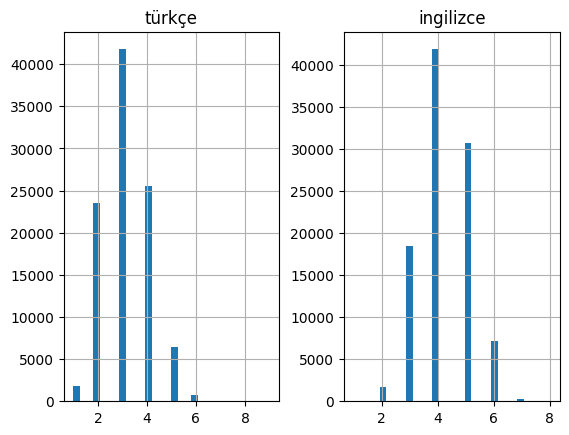

In [7]:
tr_list = []
en_list = []

# dizileri cümle uzunlukları ile doldurma
for i in tr_en["İngilizce"]:
    en_list.append(len(i.split()))

for i in tr_en["Türkçe"]:
    tr_list.append(len(i.split()))

print('Maksimum türkçe cümle uzunluğu: ', max(tr_list))
print('Maksimum ingilizce cümle uzunluğu: ', max(en_list))
length_df = pd.DataFrame({'türkçe':tr_list, 'ingilizce':en_list})
length_df.hist(bins = 30)
plt.show()

In [8]:
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

tr_tokenizer = tokenization(tr_en["Türkçe"])
tr_vocab_size = len(tr_tokenizer.word_index) + 1
max_tr_length = max(tr_list)

print('Türkçe sözlük kapasitesi: %d' % tr_vocab_size)

en_tokenizer = tokenization(tr_en["İngilizce"])
en_vocab_size = len(en_tokenizer.word_index) + 1
max_en_length = max(en_list)

print('İngilizce sözlük kapasitesi: %d' % en_vocab_size)

Türkçe sözlük kapasitesi: 29569
İngilizce sözlük kapasitesi: 9388


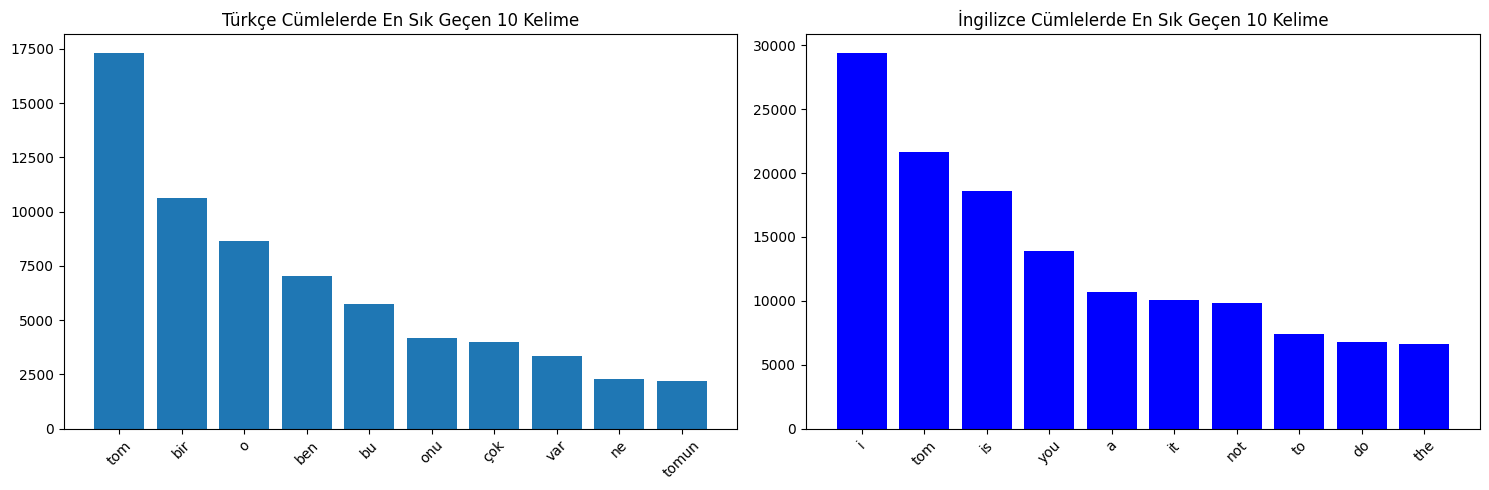

In [9]:
# Türkçe için kelime sayılarını ayıklayarak sıralama
tr_word_counts = sorted(tr_tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)
tr_top_words, tr_top_counts = zip(*tr_word_counts[:10])

# İngilizce için kelime sayılarını ayıklayarak sıralama
en_word_counts = sorted(en_tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)
en_top_words, en_top_counts = zip(*en_word_counts[:10])

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.bar(tr_top_words, tr_top_counts)
plt.title('Türkçe Cümlelerde En Sık Geçen 10 Kelime')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
plt.bar(en_top_words, en_top_counts, color='blue')
plt.title('İngilizce Cümlelerde En Sık Geçen 10 Kelime')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [10]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

## Eğitim ve Test Verisi Oluşturma

In [11]:
train,test= train_test_split(tr_en,test_size=0.2,random_state= 12)

# Eğitim verisini hazırlama
trainX = encode_sequences(tr_tokenizer, max_tr_length, train["Türkçe"])
trainY = encode_sequences(en_tokenizer, max_en_length, train["İngilizce"])

# Test verisini hazırlama
testX = encode_sequences(tr_tokenizer, max_tr_length, test["Türkçe"])
testY = encode_sequences(en_tokenizer, max_en_length, test["İngilizce"])

## Model Oluşturma

Keras ile basit modellerin oluşturulmasında **sıralı model (sequential model)** kullanılmaktadır. Daha karmaşık modellerin oluşturulmasında ise keras işlevsel API'si tercih edilmektedir. Bu proje kapsamında keras sıralı modeli kullanılacaktır.

Keras sıralı modeli oluşturulurken izlenecek adımlar sırasıyla aşağıdaki gibidir;

* Model mimarisini belirleme
* Modeli derleme (compile)
* Modeli eğitme (fit)
* Model performansını hesaplama

In [12]:
#  RNN ile Seq2seq (Diziden diziye) Modeli Oluşturma
def build_rnn_model(in_vocab, out_vocab, in_timesteps, out_timesteps, n):
    # Encoder
    encoder_inputs = Input(shape=(in_timesteps, ))
    enc_emb = Embedding(in_vocab, n, trainable=True)(encoder_inputs)
    encoder_rnn = SimpleRNN(n, return_state=True, dropout=0.4, recurrent_dropout=0.4)
    encoder_outputs, state_h = encoder_rnn(enc_emb)

    # Decoder
    decoder_inputs = RepeatVector(out_timesteps)(state_h)
    decoder_rnn = SimpleRNN(n, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
    decoder_outputs = decoder_rnn(decoder_inputs, initial_state=state_h)
    decoder_dense = TimeDistributed(Dense(out_vocab, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model(encoder_inputs, decoder_outputs)

    return model

#  LSTM ile Seq2seq (Diziden diziye) Modeli Oluşturma
def build_lstm_model(in_vocab, out_vocab, in_timesteps, out_timesteps, n):
    # Encoder
    encoder_inputs = Input(shape=(int(in_timesteps),))
    enc_emb = Embedding(in_vocab, n, trainable=True)(encoder_inputs)
    encoder_lstm = LSTM(n, return_state=True, dropout=0.4, recurrent_dropout=0.4)
    encoder_outputs, state_h, state_c = encoder_lstm(enc_emb)

    # Decoder
    decoder_inputs = RepeatVector(out_timesteps)(state_h)
    decoder_lstm = LSTM(n, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
    decoder_outputs = decoder_lstm(decoder_inputs, initial_state=[state_h, state_c])
    decoder_dense = TimeDistributed(Dense(out_vocab, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model(encoder_inputs, decoder_outputs)

    return model

#  GRU ile Seq2seq (Diziden diziye) Modeli Oluşturma
def build_gru_model(in_vocab, out_vocab, in_timesteps, out_timesteps, n):
    # Encoder
    encoder_inputs = Input(shape=(int(in_timesteps),))
    enc_emb = Embedding(in_vocab, n, trainable=True)(encoder_inputs)
    encoder_gru = GRU(n, return_state=True, dropout=0.4, recurrent_dropout=0.4)
    encoder_outputs, state_h = encoder_gru(enc_emb)

    # Decoder
    decoder_inputs = RepeatVector(out_timesteps)(state_h)
    decoder_gru = GRU(n, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
    decoder_outputs = decoder_gru(decoder_inputs, initial_state=state_h)
    decoder_dense = TimeDistributed(Dense(out_vocab, activation='softmax'))
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model(encoder_inputs, decoder_outputs)

    return model

In [13]:
rnn_model = build_rnn_model(tr_vocab_size, en_vocab_size, max_tr_length, max_en_length, num_hidden_units)
lstm_model = build_lstm_model(tr_vocab_size, en_vocab_size, max_tr_length, max_en_length, num_hidden_units)
gru_model = build_gru_model(tr_vocab_size, en_vocab_size, max_tr_length, max_en_length, num_hidden_units)

rnn_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=["accuracy"])
lstm_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=["accuracy"])
gru_model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=["accuracy"])

Model mimarisi aşağıda görüldüğü şekilde çizilebilir;

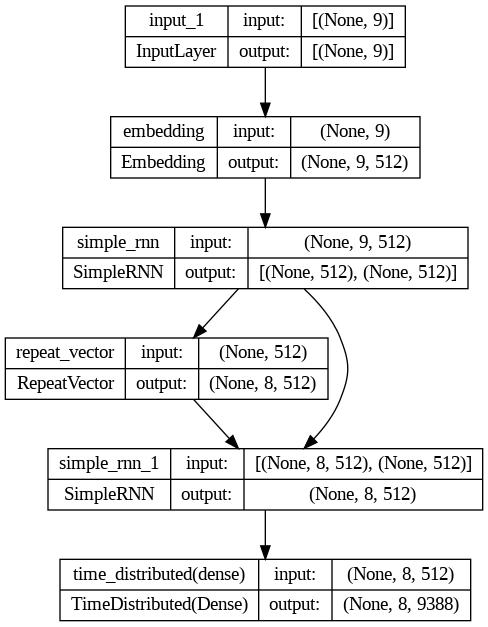

In [14]:
plot_model(rnn_model, f"RNN_modeli_{num_samples}.png", show_shapes=True, show_layer_names=True)

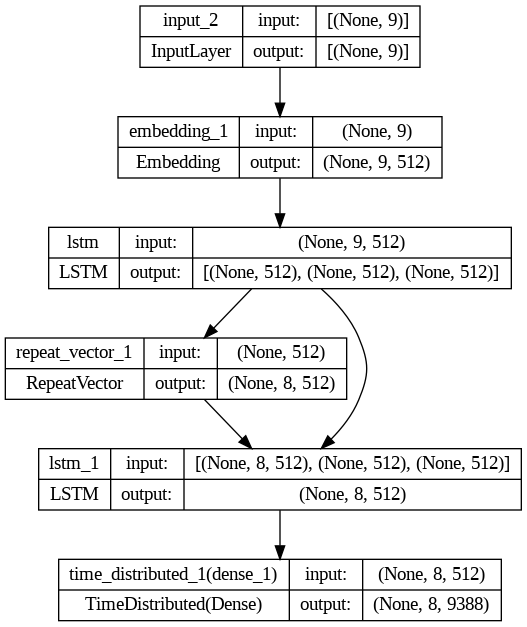

In [15]:
plot_model(lstm_model, f"LSTM_modeli_{num_samples}.png", show_shapes=True, show_layer_names=True)

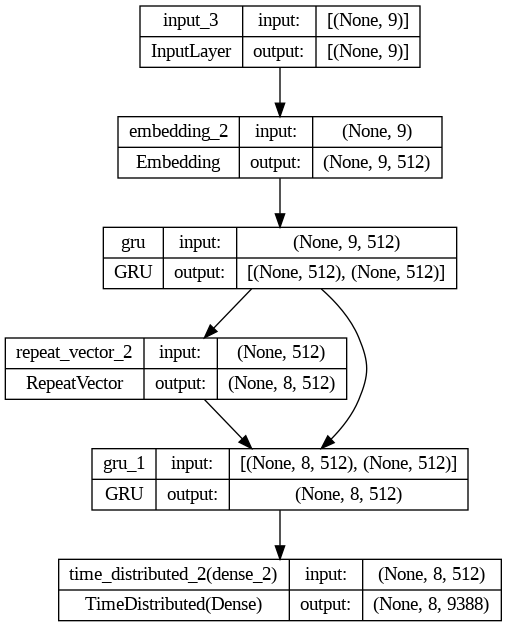

In [16]:
plot_model(gru_model, f"GRU_modeli_{num_samples}.png", show_shapes=True, show_layer_names=True)

In [17]:
rnn_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 9)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 9, 512)               1513932   ['input_1[0][0]']             
                                                          8                                       
                                                                                                  
 simple_rnn (SimpleRNN)      [(None, 512),                524800    ['embedding[0][0]']           
                              (None, 512)]                                                        
                                                                                              

In [18]:
lstm_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 9)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 9, 512)               1513932   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 lstm (LSTM)                 [(None, 512),                2099200   ['embedding_1[0][0]']         
                              (None, 512),                                                        
                              (None, 512)]                                                  

In [19]:
gru_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 9)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 9, 512)               1513932   ['input_3[0][0]']             
                                                          8                                       
                                                                                                  
 gru (GRU)                   [(None, 512),                1575936   ['embedding_2[0][0]']         
                              (None, 512)]                                                        
                                                                                            

## Modelin Eğitilmesi

In [20]:
def train_and_save_model(model, trainX, trainY, model_name, filename, epochs, batch_size):
    start_time = time.time()
    # Aşırı uyum (overfitting) sorununu önlemek amacıyla EarlyStopping kullanımı
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                        epochs=epochs, batch_size=batch_size, validation_split=0.2,
                        verbose=1, callbacks=[early_stopping])

    end_time = time.time()
    elapsed_time_minutes = (end_time - start_time) / 60

    print(f"{model_name} Modelinin eğitilmesi {elapsed_time_minutes:.2f} dakika sürdü.")

    model.save(filename)

    return history

### RNN modelinin eğitilmesi

In [21]:
rnn_history = train_and_save_model(rnn_model, trainX, trainY, "RNN", rnn_filename, epochs, batch_size)

Epoch 1/30
500/500 [==============================] - 26s 37ms/step - loss: 3.1028 - accuracy: 0.5342 - val_loss: 2.8878 - val_accuracy: 0.5562
Epoch 2/30
500/500 [==============================] - 13s 25ms/step - loss: 2.8195 - accuracy: 0.5616 - val_loss: 2.7391 - val_accuracy: 0.5724
Epoch 3/30
500/500 [==============================] - 13s 25ms/step - loss: 2.7175 - accuracy: 0.5709 - val_loss: 2.6767 - val_accuracy: 0.5776
Epoch 4/30
500/500 [==============================] - 12s 24ms/step - loss: 2.6485 - accuracy: 0.5769 - val_loss: 2.6488 - val_accuracy: 0.5772
Epoch 5/30
500/500 [==============================] - 12s 25ms/step - loss: 2.5929 - accuracy: 0.5808 - val_loss: 2.6024 - val_accuracy: 0.5856
Epoch 6/30
500/500 [==============================] - 12s 24ms/step - loss: 2.5448 - accuracy: 0.5846 - val_loss: 2.5675 - val_accuracy: 0.5870
Epoch 7/30
500/500 [==============================] - 12s 25ms/step - loss: 2.5018 - accuracy: 0.5878 - val_loss: 2.5286 - val_accuracy:

### LSTM modelinin eğitilmesi

In [22]:
lstm_history = train_and_save_model(lstm_model, trainX, trainY, "LSTM", lstm_filename, epochs, batch_size)

Epoch 1/30
500/500 [==============================] - 29s 50ms/step - loss: 3.1658 - accuracy: 0.5248 - val_loss: 2.9991 - val_accuracy: 0.5384
Epoch 2/30
500/500 [==============================] - 21s 42ms/step - loss: 2.8623 - accuracy: 0.5538 - val_loss: 2.7671 - val_accuracy: 0.5661
Epoch 3/30
500/500 [==============================] - 20s 41ms/step - loss: 2.6958 - accuracy: 0.5723 - val_loss: 2.6418 - val_accuracy: 0.5828
Epoch 4/30
500/500 [==============================] - 20s 41ms/step - loss: 2.5174 - accuracy: 0.5927 - val_loss: 2.4313 - val_accuracy: 0.6064
Epoch 5/30
500/500 [==============================] - 21s 41ms/step - loss: 2.3190 - accuracy: 0.6160 - val_loss: 2.2533 - val_accuracy: 0.6295
Epoch 6/30
500/500 [==============================] - 21s 41ms/step - loss: 2.1540 - accuracy: 0.6348 - val_loss: 2.1267 - val_accuracy: 0.6443
Epoch 7/30
500/500 [==============================] - 21s 42ms/step - loss: 2.0143 - accuracy: 0.6518 - val_loss: 2.0238 - val_accuracy:

### GRU modelinin eğitilmesi

In [23]:
gru_history = train_and_save_model(gru_model, trainX, trainY, "GRU", gru_filename, epochs, batch_size)

Epoch 1/30
500/500 [==============================] - 27s 47ms/step - loss: 3.1718 - accuracy: 0.5243 - val_loss: 2.9590 - val_accuracy: 0.5455
Epoch 2/30
500/500 [==============================] - 20s 39ms/step - loss: 2.8670 - accuracy: 0.5576 - val_loss: 2.7794 - val_accuracy: 0.5707
Epoch 3/30
500/500 [==============================] - 19s 38ms/step - loss: 2.7150 - accuracy: 0.5739 - val_loss: 2.6617 - val_accuracy: 0.5840
Epoch 4/30
500/500 [==============================] - 19s 39ms/step - loss: 2.6033 - accuracy: 0.5841 - val_loss: 2.5865 - val_accuracy: 0.5901
Epoch 5/30
500/500 [==============================] - 19s 38ms/step - loss: 2.4724 - accuracy: 0.5970 - val_loss: 2.4228 - val_accuracy: 0.6098
Epoch 6/30
500/500 [==============================] - 19s 39ms/step - loss: 2.3122 - accuracy: 0.6157 - val_loss: 2.2781 - val_accuracy: 0.6261
Epoch 7/30
500/500 [==============================] - 19s 39ms/step - loss: 2.1613 - accuracy: 0.6328 - val_loss: 2.1600 - val_accuracy:

## Model Performanslarının Değerlendirilmesi

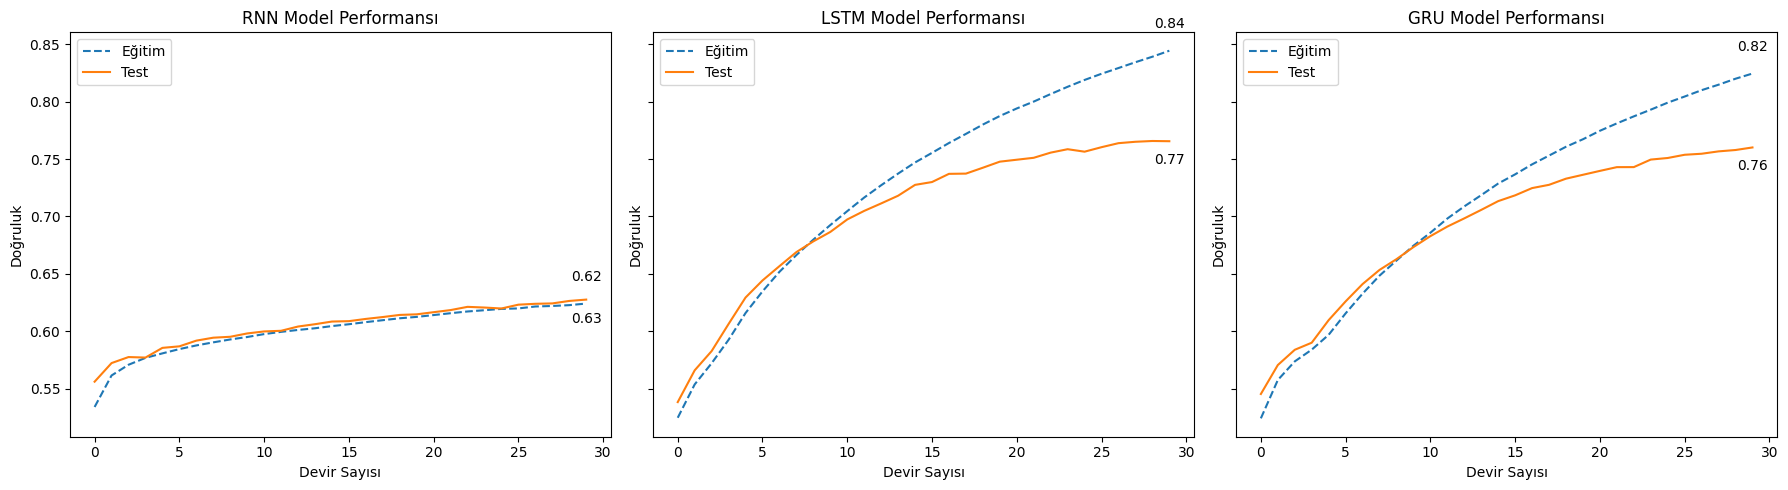

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

def annotate_last_point(ax, x, y_train, y_val, offset=0.02):
    ax.text(len(x)-1, y_train[-1] + offset, f'{y_train[-1]:.2f}', ha='center')
    ax.text(len(x)-1, y_val[-1] - offset, f'{y_val[-1]:.2f}', ha='center')

# RNN Plot
x = range(len(rnn_history.history["accuracy"]))
axs[0].plot(x, rnn_history.history["accuracy"], "--")
axs[0].plot(x, rnn_history.history["val_accuracy"])
axs[0].set_title("RNN Model Performansı")
axs[0].set_ylabel("Doğruluk")
axs[0].set_xlabel("Devir Sayısı")
axs[0].legend(["Eğitim", "Test"], loc="upper left")
annotate_last_point(axs[0], x, rnn_history.history["accuracy"], rnn_history.history["val_accuracy"])

# LSTM Plot
x = range(len(lstm_history.history["accuracy"]))
axs[1].plot(x, lstm_history.history["accuracy"], "--")
axs[1].plot(x, lstm_history.history["val_accuracy"])
axs[1].set_title("LSTM Model Performansı")
axs[1].set_ylabel("Doğruluk")
axs[1].set_xlabel("Devir Sayısı")
axs[1].legend(["Eğitim", "Test"], loc="upper left")
annotate_last_point(axs[1], x, lstm_history.history["accuracy"], lstm_history.history["val_accuracy"])

# GRU Plot
x = range(len(gru_history.history["accuracy"]))
axs[2].plot(x, gru_history.history["accuracy"], "--")
axs[2].plot(x, gru_history.history["val_accuracy"])
axs[2].set_title("GRU Model Performansı")
axs[2].set_ylabel("Doğruluk")
axs[2].set_xlabel("Devir Sayısı")
axs[2].legend(["Eğitim", "Test"], loc="upper left")
annotate_last_point(axs[2], x, gru_history.history["accuracy"], gru_history.history["val_accuracy"])

plt.tight_layout()
plt.show()

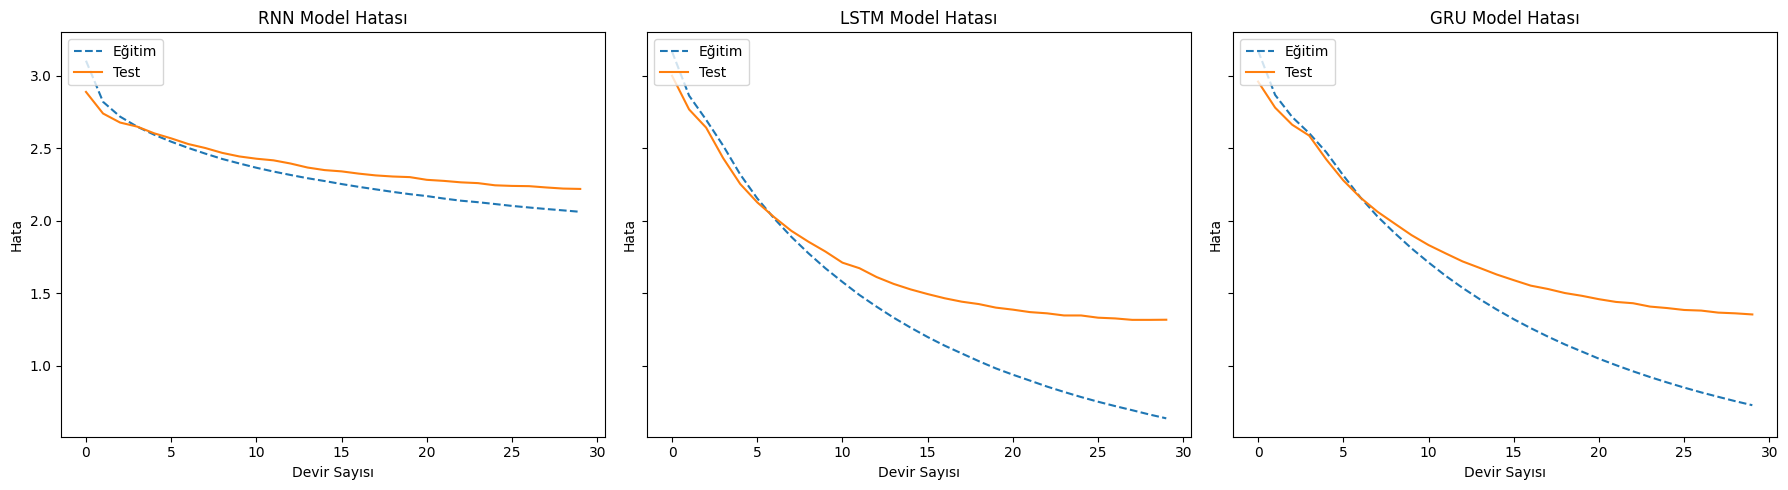

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True, sharey=True)

# RNN Plot
axs[0].plot(rnn_history.history["loss"], "--")
axs[0].plot(rnn_history.history["val_loss"])
axs[0].set_title("RNN Model Hatası")
axs[0].set_ylabel("Hata")
axs[0].set_xlabel("Devir Sayısı")
axs[0].legend(["Eğitim", "Test"], loc="upper left")

# LSTM Plot
axs[1].plot(lstm_history.history["loss"], "--")
axs[1].plot(lstm_history.history["val_loss"])
axs[1].set_title("LSTM Model Hatası")
axs[1].set_ylabel("Hata")
axs[1].set_xlabel("Devir Sayısı")
axs[1].legend(["Eğitim", "Test"], loc="upper left")

# GRU Plot
axs[2].plot(gru_history.history["loss"], "--")
axs[2].plot(gru_history.history["val_loss"])
axs[2].set_title("GRU Model Hatası")
axs[2].set_ylabel("Hata")
axs[2].set_xlabel("Devir Sayısı")
axs[2].legend(["Eğitim", "Test"], loc="upper left")

plt.tight_layout()
plt.show()

## Eğitilen Modelin Tahmin İçin Kullanılması

In [26]:
loaded_rnn_model = load_model(rnn_filename, compile=False)

loaded_rnn_model.summary()

rnn_predictions = loaded_rnn_model.predict(testX.reshape((testX.shape[0], testX.shape[1])))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 9)]                  0         []                            
                                                                                                  
 embedding (Embedding)       (None, 9, 512)               1513932   ['input_1[0][0]']             
                                                          8                                       
                                                                                                  
 simple_rnn (SimpleRNN)      [(None, 512),                524800    ['embedding[0][0]']           
                              (None, 512)]                                                        
                                                                                              

In [27]:
loaded_lstm_model = load_model(lstm_filename, compile=False)

loaded_lstm_model.summary()

lstm_predictions = loaded_lstm_model.predict(testX.reshape((testX.shape[0], testX.shape[1])))

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 9)]                  0         []                            
                                                                                                  
 embedding_1 (Embedding)     (None, 9, 512)               1513932   ['input_2[0][0]']             
                                                          8                                       
                                                                                                  
 lstm (LSTM)                 [(None, 512),                2099200   ['embedding_1[0][0]']         
                              (None, 512),                                                        
                              (None, 512)]                                                  

In [28]:
loaded_gru_model = load_model(gru_filename, compile=False)

loaded_gru_model.summary()

gru_predictions = loaded_gru_model.predict(testX.reshape((testX.shape[0], testX.shape[1])))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 9)]                  0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 9, 512)               1513932   ['input_3[0][0]']             
                                                          8                                       
                                                                                                  
 gru (GRU)                   [(None, 512),                1575936   ['embedding_2[0][0]']         
                              (None, 512)]                                                        
                                                                                            

In [30]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

def get_preds_text(predictions, tokenizer):
    preds = np.argmax(predictions, axis=-1)
    preds_text = []
    for i in preds:
        temp = []
        for j in range(len(i)):
            t = get_word(i[j], tokenizer)
            if j > 0:
                if (t == get_word(i[j-1], tokenizer)) or (t == None):
                    temp.append('')
                else:
                    temp.append(t)
            else:
                if(t == None):
                    temp.append('')
                else:
                    temp.append(t)
        preds_text.append(' '.join(temp))
    return preds_text

rnn_preds_text = get_preds_text(rnn_predictions, en_tokenizer)
lstm_preds_text = get_preds_text(lstm_predictions, en_tokenizer)
gru_preds_text = get_preds_text(gru_predictions, en_tokenizer)

pred_df = pd.DataFrame({
    'Türkçe': test["Türkçe"],
    'İngilizce': test["İngilizce"],
    'RNN Tahmin': rnn_preds_text,
    'LSTM Tahmin': lstm_preds_text,
    'GRU Tahmin': gru_preds_text
})

sample_indices = pred_df.sample(15).index
displayed_samples = pred_df.loc[sample_indices]
print(displayed_samples)

                           Türkçe                İngilizce  \
4146            açlıktan ölüyorum            i am starving   
35667  tom şanslı olduğundan emin        tom sure is lucky   
26799     biz onun dansını gördük         we saw her dance   
82018         ben oldukça iyiydim  i have been pretty good   
43974       bu saçmalıktan vazgeç       stop this nonsense   
39251                o bir kaleci      he is a goal keeper   
20804            o bir kedi sever        he is a cat lover   
1711            evde kimse var mı              anyone home   
33147            o soprano söyler        she sings soprano   
94052    ben hiçbir şeyi yakmadım  i did not burn anything   
4001         ben yalnız yaşıyorum            i am a hermit   
42470               bugün bulutlu       it is cloudy today   
27806                sen naziksin        you are courteous   
66795  size bir taksi çağıracağım   i will call you a taxi   
30006           sanırım hatalıyım       i guess i am wrong   

       

In [31]:
def calculate_bleu_scores(references, candidates):
    chencherry = SmoothingFunction()

    scores_1gram = []
    scores_2gram = []
    scores_3gram = []
    scores_4gram = []
    scores_cumulative = []

    for ref, cand in zip(references, candidates):
        ref_list = [ref.split()]
        cand_list = cand.split()

        scores_1gram.append(sentence_bleu(ref_list, cand_list, weights=(1, 0, 0, 0), smoothing_function=chencherry.method1))
        scores_2gram.append(sentence_bleu(ref_list, cand_list, weights=(0, 1, 0, 0), smoothing_function=chencherry.method1))
        scores_3gram.append(sentence_bleu(ref_list, cand_list, weights=(0, 0, 1, 0), smoothing_function=chencherry.method1))
        scores_4gram.append(sentence_bleu(ref_list, cand_list, weights=(0, 0, 0, 1), smoothing_function=chencherry.method1))
        scores_cumulative.append(sentence_bleu(ref_list, cand_list, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=chencherry.method1))

    return {
        "1-gram": sum(scores_1gram) / len(scores_1gram),
        "2-gram": sum(scores_2gram) / len(scores_2gram),
        "3-gram": sum(scores_3gram) / len(scores_3gram),
        "4-gram": sum(scores_4gram) / len(scores_4gram),
        "Cumulative": sum(scores_cumulative) / len(scores_cumulative)
    }

references = test["İngilizce"]

rnn_bleu_scores = calculate_bleu_scores(references, get_preds_text(rnn_predictions, en_tokenizer))
lstm_bleu_scores = calculate_bleu_scores(references, get_preds_text(lstm_predictions, en_tokenizer))
gru_bleu_scores = calculate_bleu_scores(references, get_preds_text(gru_predictions, en_tokenizer))

print("RNN BLEU Puanı:")
for key, value in rnn_bleu_scores.items():
    print(f"{key}: {value:.4f}")

print("\nLSTM BLEU Puanı:")
for key, value in lstm_bleu_scores.items():
    print(f"{key}: {value:.4f}")

print("\nGRU BLEU Puanı:")
for key, value in gru_bleu_scores.items():
    print(f"{key}: {value:.4f}")

RNN BLEU Puanı:
1-gram: 0.3257
2-gram: 0.1440
3-gram: 0.0960
4-gram: 0.0668
Cumulative: 0.1114

LSTM BLEU Puanı:
1-gram: 0.6150
2-gram: 0.4215
3-gram: 0.3105
4-gram: 0.2234
Cumulative: 0.3216

GRU BLEU Puanı:
1-gram: 0.5978
2-gram: 0.4056
3-gram: 0.2930
4-gram: 0.2073
Cumulative: 0.3048
